In [127]:
#First, import the necessary packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


In [128]:
#create the colormap we want for the heatmaps examples: white -> blue -> red

colors = [(1, 1, 1), (0.78, 0.84, 0.94), (0.92, 0.69, 0.65)]  # R -> G -> B
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'white_blue_red'

# Create the colormap
cmap_wbr = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


# Initial data import and merge with ReDU table

In [129]:
#Import all the outputs from fastMASST
Phe_C4 = pd.read_csv('/Users/helenarusso/Downloads/Phe-C4.csv', sep=',')
Phe_CA = pd.read_csv('/Users/helenarusso/Downloads/Phe-CA.csv', sep=',')
His_C4 = pd.read_csv('/Users/helenarusso/Downloads/His-C4.csv', sep=',')

#Filter the 'Delta Mass' column so that the tolerances are within the specified ones
Phe_C4 = Phe_C4[(Phe_C4['Delta Mass'] >= -0.05) & (Phe_C4['Delta Mass'] <= 0.05)]
Phe_CA = Phe_CA[(Phe_CA['Delta Mass'] >= -0.05) & (Phe_CA['Delta Mass'] <= 0.05)]
His_C4 = His_C4[(His_C4['Delta Mass'] >= -0.05) & (His_C4['Delta Mass'] <= 0.05)]

#Create a 'Compound' column indicating from which compound each of the outputs is relative to
Phe_C4['Compound'] = 'Phenylalanine-C4:0'
Phe_CA['Compound'] = 'Phenylalanine-CA'
His_C4['Compound'] = 'Histidine-C4:0'

#And let's concatenate all of them vertically to have all in one dataframe
df = pd.concat([Phe_C4, Phe_CA, His_C4], axis=0)
df = df.reset_index(drop=True)

#Create a new column in the format Dataset/Filename
df['filepath'] = df['Dataset'] + "/" + df['USI'].str.split('/').str[-1]
df['filepath'] = df['filepath'].str.split(':').str[0] #remove scan number
df['filepath'] = df['filepath'].str.replace('.mzML', '') #remove mzML extension
df['filepath'] = df['filepath'].str.replace('.mzXML', '') #remove mzXML extension


In [130]:
#Import ReDU table (can be downloaded from https://redu.gnps2.org/)
#For the example in this protocol, the ReDU table was doenloaded in July2nd, 2024
df_redu = pd.read_csv('/Users/helenarusso/Downloads/all_sampleinformation.tsv', sep='\t')

#Create new column 'filename_2' with the file name, remove the .mzML and .mzXML extensions, and create
#another column in the Dataset/Filename format
df_redu['filename_2'] = df_redu['filename'].str.split('/').str[-1]
df_redu['filename_2'] = df_redu['filename_2'].str.replace('.mzML', '')
df_redu['filename_2'] = df_redu['filename_2'].str.replace('.mzXML', '')
df_redu['filepath'] = df_redu['ATTRIBUTE_DatasetAccession'].astype(str).str.cat(df_redu[['filename_2']].astype(str),
                                                                                sep='/')

#Merge with the fastMASST result table on the 'filepath' column created for the two dataframes
df_merged = pd.merge(df, df_redu, on='filepath', how='left')

#Standardize all the skin body parts to only 'skin', and blood plasma and serum to 'blood'
df_merged['UBERONBodyPartName'] = df_merged['UBERONBodyPartName'].str.replace('skin of trunk','skin')
df_merged['UBERONBodyPartName'] = df_merged['UBERONBodyPartName'].str.replace('skin of pes','skin')
df_merged['UBERONBodyPartName'] = df_merged['UBERONBodyPartName'].str.replace('head or neck skin','skin')
df_merged['UBERONBodyPartName'] = df_merged['UBERONBodyPartName'].str.replace('axilla skin','skin')
df_merged['UBERONBodyPartName'] = df_merged['UBERONBodyPartName'].str.replace('skin of manus','skin')
df_merged['UBERONBodyPartName'] = df_merged['UBERONBodyPartName'].str.replace('arm skin','skin')
df_merged['UBERONBodyPartName'] = df_merged['UBERONBodyPartName'].str.replace('blood plasma','blood')
df_merged['UBERONBodyPartName'] = df_merged['UBERONBodyPartName'].str.replace('blood serum','blood')


In [131]:
#Now let's split into human-related data and rodent-related data

df_humans = df_merged.loc[df_merged['NCBITaxonomy'] == '9606|Homo sapiens']

list_rodents = ['10088|Mus','10090|Mus musculus','10105|Mus minutoides','10114|Rattus', '10116|Rattus norvegicus']
df_rodents = df_merged[df_merged['NCBITaxonomy'].isin(list_rodents)]

# Counts table

In [132]:
#Now we can write a function to get us a table summarizing all the different compounds and number of scans
#retrieved in fastMASST for all the body parts

In [133]:
def analyze_counts(df, column_interest):
    '''
    Prepare a table with counts of the fastMASST results.
    
    Parameters:
    - df: A dataframe with the fastMASST results merged with ReDU table. In this example, df_humans or df_rodents.
    - column_interest: The name of the column to calculate the counts.
    
    Returns:
    - A DataFrame containing counts of each compound for each of the entries in the column specified.
    '''
    
    
    #create a list of all the body parts and create a dataframe for these body parts
    list_body_parts = df[column_interest].unique().tolist()
    df_body_parts = pd.DataFrame(list_body_parts, columns=[column_interest])
    
    #count occurrences of each UBERONBodyPartName in the input data
    df_BodyPartName_counts = df[column_interest].value_counts().rename_axis(column_interest).reset_index(name='Counts_fastMASST')
                      
    # Aggregate the number and list of unique Compounds for each body part
    compounds = df.groupby(column_interest)['Compound'].agg(['nunique', lambda x: ', '.join(map(str, x.unique()))]).reset_index()
    compounds.columns = [column_interest, 'Compounds', 'CompoundsList']
    
    # Merge all the data into a single DataFrame
    combined = pd.merge(df_body_parts, df_BodyPartName_counts, on=column_interest, how='left')
    combined = pd.merge(combined, compounds, on=column_interest, how='left')

    return combined
    

In [134]:
#To use the function above, enter df_rodents or df_humans, and select the column you want to create a counts table
body_counts = analyze_counts(df_humans, 'UBERONBodyPartName')
body_counts.head()

,UBERONBodyPartName,Counts_fastMASST,Compounds,CompoundsList
0,feces,571,3,"Phenylalanine-C4:0, Phenylalanine-CA, Histidin..."
1,missing value,12,2,"Phenylalanine-C4:0, Histidine-C4:0"
2,urine,3,2,"Phenylalanine-C4:0, Histidine-C4:0"
3,saliva,2,1,Phenylalanine-C4:0
4,oral cavity,2,2,"Phenylalanine-C4:0, Phenylalanine-CA"


# Heatmaps - Counts

In [135]:
#We can also write another function to get us a pivot table for heatmap plot.
#This section of the notebook will focus on getting the counts obseved for each body part.

In [136]:
def prepare_pivot_table(df, column_interest, compound):
    
    '''
    Prepare a pivot table with counts of the fastMASST results for each compound in each value of the 
    desired ReDU column.
    
    Parameters:
    - df: A dataframe with the fastMASST results merged with ReDU table. In this example, df_humans or df_rodents.
    - column_interest: The name of the column to calculate the counts. This column will be used as rows in the 
    pivot table.
    - compound: The name of the column that will be used to calculate counts. This column will be used as columns 
    in the pivot table.
    
    Returns:
    - A DataFrame containing counts of each compound for each of the entries in the column specified.
    Each column will be each of the compounds inputed (imported from the fastMASST results).
    
    '''

    # Group 'Compound' and the column of interest from ReDU to create the heatmap, and count the occurrences
    grouped_df = df.groupby([compound, column_interest]).size().reset_index(name='Count')
    
    # Create a pivot table with the the grouped dataframe (each compound in a column)
    pivot_table = grouped_df.pivot(index=column_interest, columns=compound, values='Count').fillna(0)
    pivot_table.reset_index(inplace=True)
    
    
    return pivot_table

In [137]:
# Apply the function to retrieve a table to be used to create heatmaps

variable = 'UBERONBodyPartName'   #Select the column from ReDU you would like to get heatmaps on

pivot_table = prepare_pivot_table(df_rodents, variable, 'Compound')

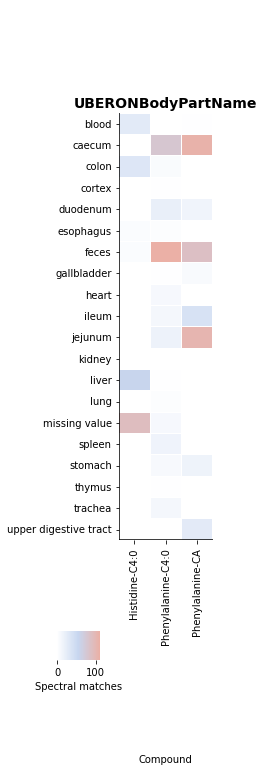

In [138]:
###########################################################################################
###########################################################################################

## IMPORTANT: MORE INFORMATION CAN BE FOUND IN THE MATPLOTLIB AND SEABORN DOCUMENTATIONS ##
## THIS IS JUST AN EXAMPLE OF HOW THESE PACKAGES CAN BE USED TO GENERATE A HEATMAP OF THE #
## FASST SEARCHES RESULTS  ################################################################

###########################################################################################
###########################################################################################

columns_for_heatmap = pivot_table.columns[1:]  #Specify that the first column should not be used for the heatmap
                                               #construction since it is categorical
fig = sns.clustermap(
    pivot_table[columns_for_heatmap], 
    col_cluster=False,    #This can be set as True or False in case you want the columns to cluster
    row_cluster=False,    #This can be set as True or False in case you want the rows to cluster
    cmap = cmap_wbr,      #Let's use the colormap created at the beginning of the script. More are available in
                          #the matplotlib documentation.
    yticklabels=pivot_table[variable],  #Define tick labels as the column with the pre-selected variable
    linewidths=0.005,
    linecolor = 'white',
    cbar_kws={'orientation': 'horizontal'}
)

fig.ax_heatmap.yaxis.set_ticks_position('left')  # Y ticks position to the left
fig.ax_heatmap.yaxis.set_label_position('left')  # Y labels position to the left
fig.ax_heatmap.set_xticklabels(fig.ax_heatmap.get_xticklabels(), rotation=90)  #Rotate 90 degrees the X labels

cax = fig.ax_cbar  #Create a figure for the colorbar
cax.set_position([-0.25, -0.15, .3, .05])  # Adjust the position and size of the color bar
cbar = fig.ax_heatmap.collections[0].colorbar   #Retrieves the color bar object
cbar.set_label('Spectral matches', fontsize=10)  # Set the desired font size for the color bar label

fig.ax_heatmap.xaxis.set_label_coords(0.5, -0.5) #coordinate X axis title - more to the bottom

heatmap_title = f"{variable}"  #Define the title
heatmap_title_obj = fig.ax_heatmap.set_title(heatmap_title, fontsize=14, weight='bold') #Define Title layout

line_count = len(pivot_table[variable].unique())
fig.ax_heatmap.axhline(y=line_count, color='black', linewidth=1.5)  #Define position of the horizontal black line 
                                                                    #(same length as the number of rows)
fig.ax_heatmap.axvline(x=0, color='black', linewidth=1.5)    #Define position of the vertical line - zero

plt.gcf().set_size_inches(2, 8)    #Set the size of the final figure

# fig.savefig('.../heatmap.pdf')


# Heatmaps - Counts in log scale

In [139]:
def prepare_pivot_table(df, column_interest, compound):
    
    '''
    Prepare a pivot table with counts of the fastMASST results for each compound in each value of the 
    desired ReDU column.
    
    Parameters:
    - df: A dataframe with the fastMASST results merged with ReDU table. In this example, df_humans or df_rodents.
    - column_interest: The name of the column to calculate the counts. This column will be used as rows in the 
    pivot table.
    - compound: The name of the column that will be used to calculate counts. This column will be used as columns 
    in the pivot table.
    
    Returns:
    - A DataFrame containing counts of each compound for each of the entries in the column specified.
    Each column will be each of the compounds inputed (imported from the fastMASST results).
    
    '''

    # Group 'Compound' and the column of interest from ReDU to create the heatmap, and count the occurrences
    grouped_df = df.groupby([compound, column_interest]).size().reset_index(name='Count')
    
    # Create a pivot table with the the grouped dataframe (each compound in a column)
    pivot_table = grouped_df.pivot(index=column_interest, columns=compound, values='Count').fillna(0)
    pivot_table.reset_index(inplace=True)
    
    #log2 transform
    columns_for_heatmap = pivot_table.columns[1:] #Not consider the first column with the body parts
    pivot_table[columns_for_heatmap] = pivot_table[columns_for_heatmap] + 1
    log_transformed = np.log2(pivot_table[columns_for_heatmap])
    log_transformed = pd.concat([pivot_table[column_interest], log_transformed], axis=1)
    
    return log_transformed

In [140]:
# Apply the function to retrieve a table to be used to create heatmaps

variable = 'UBERONBodyPartName'   #Select the column from ReDU you would like to get heatmaps on

log_transformed = prepare_pivot_table(df_rodents, variable, 'Compound')

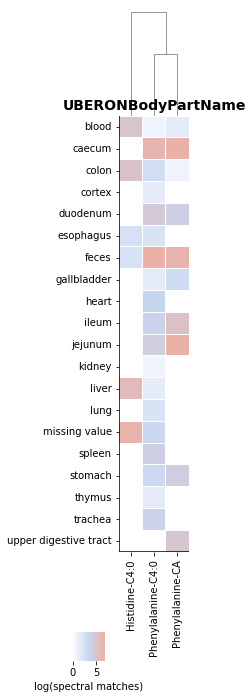

In [141]:
###########################################################################################
###########################################################################################

## IMPORTANT: MORE INFORMATION CAN BE FOUND IN THE MATPLOTLIB AND SEABORN DOCUMENTATIONS ##
## THIS IS JUST AN EXAMPLE OF HOW THESE PACKAGES CAN BE USED TO GENERATE A HEATMAP OF THE #
## FASTMASST RESULTS  #####################################################################

###########################################################################################
###########################################################################################

columns_for_heatmap = log_transformed.columns[1:]  #Specify that the first column should not be used for the heatmap
                                               #construction since it is categorical
fig = sns.clustermap(
    log_transformed[columns_for_heatmap], 
    col_cluster=True,     #This can be set as True or False in case you want the columns to cluster
    method = 'complete',  #Example with method = complete
    metric = 'euclidean', #Example with euclidean distance
    row_cluster=False,    #This can be set as True or False in case you want the rows to cluster
    cmap = cmap_wbr,      #Let's use the colormap created at the beginning of the script. More are available in
                          #the matplotlib documentation.
    yticklabels=log_transformed[variable],  #Define tick labels as the column with the pre-selected variable
    linewidths=0.005,
    linecolor = 'white',
    cbar_kws={'orientation': 'horizontal'}
)

fig.ax_heatmap.yaxis.set_ticks_position('left')  # Y ticks position to the left
fig.ax_heatmap.yaxis.set_label_position('left')  # Y labels position to the left
fig.ax_heatmap.set_xticklabels(fig.ax_heatmap.get_xticklabels(), rotation=90)  #Rotate 90 degrees the X labels

cax = fig.ax_cbar  #Create a figure for the colorbar
cax.set_position([-0.25, -0.15, .3, .05])  # Adjust the position and size of the color bar
cbar = fig.ax_heatmap.collections[0].colorbar   #Retrieves the color bar object
cbar.set_label('log(spectral matches)', fontsize=10)  # Set the desired font size for the color bar label

fig.ax_heatmap.xaxis.set_label_coords(0.5, -0.5) #coordinate X axis title - more to the bottom

heatmap_title = f"{variable}"  #Define the title
heatmap_title_obj = fig.ax_heatmap.set_title(heatmap_title, fontsize=14, weight='bold') #Define Title layout

line_count = len(log_transformed[variable].unique())
fig.ax_heatmap.axhline(y=line_count, color='black', linewidth=1.5)  #Define position of the horizontal black line 
                                                                    #(same length as the number of rows)
fig.ax_heatmap.axvline(x=0, color='black', linewidth=1.5)    #Define position of the vertical line - zero

plt.gcf().set_size_inches(1.5, 8)    #Set the size of the final figure

# fig.savefig('.../heatmap.pdf')


# Heatmaps - Normalization based on ReDU

In [142]:
#We can also write another function to get us a pivot table for heatmap plot with data normalized to what is
#available in ReDU. In this way, we also take into account the amount of data available in the public domain.
#This section of the notebook will focus on getting the normalized counts obseved for each HealthStatus.

#This is important because there might be more data from specific diseases in the public domain compared to 
#others, and then associations can be skewed based on data availability.

#In this example, we want to show the disease distribution (DOIDCommonName column in ReDU). Therefore, we 
#first need to get the information of how many files are there for each DOIDCommonName in ReDU - both for humans
# and rodents

In [143]:
#Split the ReDU table into human-related data and rodent-related data

df_redu_humans = df_redu.loc[df_redu['NCBITaxonomy'] == '9606|Homo sapiens']

list_rodents = ['10088|Mus','10090|Mus musculus','10105|Mus minutoides','10114|Rattus', '10116|Rattus norvegicus']
df_redu_rodents = df_redu[df_redu['NCBITaxonomy'].isin(list_rodents)]

#And retrieve how many files are there for each DOIDCommonName in each organism
df_redu_DOIDCommonName_humans = df_redu_humans['DOIDCommonName'].value_counts().reset_index().rename(columns={"index": "DOIDCommonName", 'DOIDCommonName': 'DOIDCommonName_counts'})
df_redu_DOIDCommonName_rodents = df_redu_rodents['DOIDCommonName'].value_counts().reset_index().rename(columns={"index": "DOIDCommonName", 'DOIDCommonName': 'DOIDCommonName_counts'})


In [144]:
def prepare_pivot_table(df, column_interest, compound, df_redu_DOIDCommonName, redu_count_col):
    
    '''
    Prepare a pivot table with counts of the fastMASST results for each compound in each value of the 
    desired ReDU column.
    
    Parameters:
    - df: A dataframe with the fastMASST results merged with ReDU table. In this example, df_humans or df_rodents.
    - column_interest: The name of the column to calculate the counts. This column will be used as rows in the 
    pivot table.
    - compound: The name of the column that will be used to calculate counts. This column will be used as columns 
    in the pivot table.
    
    Returns:
    - A DataFrame containing counts of each compound for each of the entries in the column specified.
    Each column will be each of the compounds inputed (imported from the fastMASST results).
    
    '''

    # Group 'Compound' and the column of interest from ReDU to create the heatmap, and count the occurrences
    grouped_df = df.groupby([compound, column_interest]).size().reset_index(name='Count')
    
    # Create a pivot table with the the grouped dataframe (each compound in a column)
    pivot_table = grouped_df.pivot(index=column_interest, columns=compound, values='Count').fillna(0)
    pivot_table.reset_index(inplace=True)
    
    # Merge with ReDU DOIDCommonName dataframe for normalization
    pivot_table = pd.merge(pivot_table, df_redu_DOIDCommonName, on=column_interest, how='left')
    
    # Normalize the pivot table (divide the counts from fastMASST by the number of files available on ReDU for
    # each DOIDCommonName)
    columns_to_normalize = pivot_table.columns.difference([column_interest, redu_count_col])
    pivot_table[columns_to_normalize] = pivot_table[columns_to_normalize].div(pivot_table[redu_count_col], axis=0)
    pivot_table.drop(redu_count_col, axis=1, inplace=True)
    
    #To get the relative abundance (based on counts) calculation for each compound, we need to first sum up the 
    #values for each column (Compound)
    sums = pivot_table.select_dtypes(include='number').sum().to_dict()
    sums['DOIDCommonName'] = 'Sum'  
    pivot_table = pivot_table.append(sums, ignore_index=True)  #create a new row with the Sum values for each column
    
    # Normalize each numeric column by the total to get the percentages
    for column in pivot_table.select_dtypes(include='number').columns:
        total_value = pivot_table[column].iloc[-1]  # Get the total from the last row of the column
        pivot_table[column] = pivot_table[column] / total_value * 100

    #drop the sum row
    pivot_table = pivot_table.drop(pivot_table[pivot_table['DOIDCommonName'] == 'Sum'].index)
    
    
    return pivot_table

In [145]:
# Apply the function to retrieve a table to be used to create heatmaps
# Make sure to specify df_rodents and df_redu_DOIDCommonName_rodents or df_humans and 
# df_humans_DOIDCommonName_rodents for our examples.

column_interest = 'DOIDCommonName'   #Select the column from ReDU you would like to get heatmaps on

pivot_table = prepare_pivot_table(df_humans, column_interest, 'Compound', df_redu_DOIDCommonName_humans,
                          f'{column_interest}_counts')

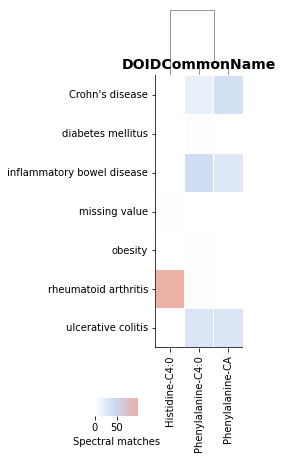

In [146]:
###########################################################################################
###########################################################################################

## IMPORTANT: MORE INFORMATION CAN BE FOUND IN THE MATPLOTLIB AND SEABORN DOCUMENTATIONS ##
## THIS IS JUST AN EXAMPLE OF HOW THESE PACKAGES CAN BE USED TO GENERATE A HEATMAP OF THE #
## FASTMASST RESULTS  #####################################################################

###########################################################################################
###########################################################################################

columns_for_heatmap = pivot_table.columns[1:]  #Specify that the first column should not be used for the heatmap
                                               #construction since it is categorical
fig = sns.clustermap(
    pivot_table[columns_for_heatmap], 
    col_cluster=True,     #This can be set as True or False in case you want the columns to cluster
    method = 'complete',  #Example with method = complete
    metric = 'euclidean', #Example with euclidean distance
    row_cluster=False,    #This can be set as True or False in case you want the rows to cluster
    cmap = cmap_wbr,      #Let's use the colormap created at the beginning of the script. More are available in
                          #the matplotlib documentation.
    yticklabels=pivot_table[column_interest],  #Define tick labels as the column with the pre-selected variable
    linewidths=0.005,
    linecolor = 'white',
    cbar_kws={'orientation': 'horizontal'}
)

fig.ax_heatmap.yaxis.set_ticks_position('left')  # Y ticks position to the left
fig.ax_heatmap.yaxis.set_label_position('left')  # Y labels position to the left
fig.ax_heatmap.set_xticklabels(fig.ax_heatmap.get_xticklabels(), rotation=90)  #Rotate 90 degrees the X labels

cax = fig.ax_cbar  #Create a figure for the colorbar
cax.set_position([-0.25, -0.15, .3, .05])  # Adjust the position and size of the color bar
cbar = fig.ax_heatmap.collections[0].colorbar   #Retrieves the color bar object
cbar.set_label('Spectral matches', fontsize=10)  # Set the desired font size for the color bar label

fig.ax_heatmap.xaxis.set_label_coords(0.5, -0.5) #coordinate X axis title - more to the bottom

heatmap_title = f"{column_interest}"  #Define the title
heatmap_title_obj = fig.ax_heatmap.set_title(heatmap_title, fontsize=14, weight='bold') #Define Title layout

line_count = len(pivot_table[column_interest].unique())
fig.ax_heatmap.axhline(y=line_count, color='black', linewidth=1.5)  #Define position of the horizontal black line 
                                                                    #(same length as the number of rows)
fig.ax_heatmap.axvline(x=0, color='black', linewidth=1.5)    #Define position of the vertical line - zero

plt.gcf().set_size_inches(2, 5)    #Set the size of the final figure

# fig.savefig('.../heatmap.pdf')
